## **GIS Analysis of Service NOW Company A Company J data**

Import packages

In [1]:
import numpy as np
import pandas as pd
import plotly
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import statsmodels.api as sm
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


**Begin Analysis for Company A - US Locations**

In [ ]:
#Open the csv of US data, category, ticket duration in hours (Company A)
df = pd.read_csv('/content/drive/Shareddrives/IST 718 Project/us_locations.csv')
df.head()

city state       actual_category      hours
0   san diego    ca              security   0.100000
1       tampa    fl              software  24.200000
2     raleigh    nc     computer hardware  22.383333
3    portland    or              software   0.933333
4  manchester    nh  access-issue/request  76.733333

In [ ]:
#Concatenate city state to location (Company A)
df['location'] = df['city'].str.cat(df['state'],sep=", ")
df.head()

city state       actual_category      hours        location
0   san diego    ca              security   0.100000   san diego, ca
1       tampa    fl              software  24.200000       tampa, fl
2     raleigh    nc     computer hardware  22.383333     raleigh, nc
3    portland    or              software   0.933333    portland, or
4  manchester    nh  access-issue/request  76.733333  manchester, nh

**Descriptive Statistics of Company A Data**


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



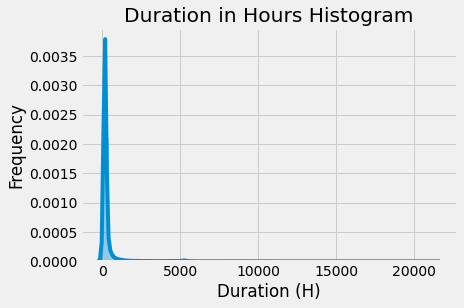

In [ ]:
# CREATE A HISTOGRAM OF Time Duration in Hours (Company A)
import matplotlib.pyplot as plt 
import seaborn as sns
ax = sns.distplot(df['hours'])
plt.title("Duration in Hours Histogram")
plt.xlabel('Duration (H)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Create violin plots of ticket duration by category (Company A)
import plotly.express as px
fig = px.violin(df, y="hours", x="actual_category", box=True, # draw box plot inside the violin
                points="all", 
               )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Remove outliers
df2 = df[df.hours<(90*24)]

In [ ]:
#Create box plots of ticket duration by category, outliers removed (Company A)
import plotly.express as px
fig = px.box(df2, x="actual_category", y="hours", color_discrete_sequence=px.colors.qualitative.Vivid, points="all")
fig.show()

In [ ]:
#Create boxplots by location Company A
fig = px.box(df2, x="location", y="hours", color="state")
fig.show()

# **Examine Company A Data in geospatial environment**

In [ ]:
#Get the geo-locations for each of origin locations
#Data were retrived using a seconday colab file

In [ ]:
#Read in csv with new locations form Company A US locations
df3 = pd.read_csv('/content/drive/Shareddrives/IST 718 Project/us_loc_2k.csv')
df3.head()

Unnamed: 0        city state  ...   latitude   longitude altitude
0           0   san diego    ca  ...  32.717420 -117.162773      0.0
1           1       tampa    fl  ...  27.947759  -82.458444      0.0
2           2     raleigh    nc  ...  35.780398  -78.639099      0.0
3           3    portland    or  ...  45.520247 -122.674195      0.0
4           4  manchester    nh  ...  42.995640  -71.454789      0.0

[5 rows x 11 columns]

In [ ]:
#Plot Company A US Locations ticket duratioon on map colored by category 
mapbox_access_token = 'pk.eyJ1IjoidnNtaWxsZXIiLCJhIjoiY2tpMmgwMW10MmZ6cDJ6bnR3cnZ6N2E0eSJ9.Hs3fSyL7D862FtohKmTALg'
px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_mapbox(df3, lat="latitude", lon="longitude", color="actual_category", size="hours",
                  color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=10, zoom=3, mapbox_style='dark')
fig.show()

In [ ]:
#Plot a heat map of ticket duration (Company A)
fig = px.density_mapbox(df3, lat='latitude', lon='longitude', z='hours', radius=10,
                        center=dict(lat=40, lon=-90), zoom=3,
                        mapbox_style="stamen-toner")
fig.show()
fig.write_html('/content/drive/Shareddrives/IST 718 Project/us_layer_companyA_map.html', full_html=False, include_plotlyjs='cdn')

In [ ]:
#Company A, map layers folium map
import folium 
#Create map project
m = folium.Map(location=[38.395, -96.544], zoom_start=5)
#add tiles to the map
folium.raster_layers.TileLayer('Open Street Map').add_to(m)
folium.raster_layers.TileLayer('Stamen Toner').add_to(m)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(m)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(m)

#add layer control to show differenc maps
folium.LayerControl().add_to(m)

#plot the location of the service calls
for (index, row) in df3.iterrows():
  folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], popup=row.loc['city']+ '  ' + row.loc['actual_category'],\
                icon=folium.Icon(color='orange',icon='wrench',prefix='fa'), tooltip='click').add_to(m)

#display map
m.save('/content/drive/Shareddrives/IST 718 Project/us_layer_map.html')
m


Output hidden; open in https://colab.research.google.com to view.

# **Examine Sites that closed the SNOW request and Number of Tickets Closed**

In [ ]:
#Examined data by the site that closed the ticket
dfc = pd.read_csv('/content/drive/Shareddrives/IST 718 Project/closed_by_locations.csv')
dfc.head()

Unnamed: 0           city state  ...   latitude   longitude altitude
0           0    los angeles    ca  ...  34.053691 -118.242766      0.0
1           1  san francisco    ca  ...  37.779026 -122.419906      0.0
2           2       new york    ny  ...  40.712728  -74.006015      0.0
3           3         dallas    tx  ...  32.776272  -96.796856      0.0
4           4    hunt valley    md  ...  39.492261  -76.658953      0.0

[5 rows x 11 columns]

In [ ]:
#Closing site location map layers folium map
import folium 
#Create map project
mc = folium.Map(location=[38.395, -96.544], zoom_start=5)
#add tiles to the map
folium.raster_layers.TileLayer('Stamen Toner').add_to(mc)

#add layer control to show differenc maps
folium.LayerControl().add_to(mc)

#plot the location of the service calls
for (index, row) in dfc.iterrows():
  folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], popup=row.loc['city']+ '  ' + row.loc['state'],\
                icon=folium.Icon(color='blue',icon='check-circle',prefix='fa'), tooltip='click').add_to(mc)

#display map
mc.save('/content/drive/Shareddrives/IST 718 Project/closed_by_site_map_layers.html')
mc


In [ ]:
#Create a list for the heatmap
closed_by_list = [[row['latitude'],row['longitude'], row['number']] for index, row in dfc.iterrows()]


In [ ]:
from folium import plugins
map_heatmap1 = folium.Map([39.394, -96.544],zoom_start=5)
folium.raster_layers.TileLayer('CartoDB dark_matter').add_to(map_heatmap1)
plugins.HeatMap(closed_by_list).add_to(map_heatmap1)
map_heatmap1.save('/content/drive/Shareddrives/IST 718 Project/closed_by_ticket_duration_heat.html')
map_heatmap1

# **Examine Company J Data in geospatial environment**

In [ ]:
#Perform the analysis for company J
j_df = pd.read_csv('/content/drive/Shareddrives/IST 718 Project/comp_j_locations.csv')
df.dropna(axis=0, how='any',subset=None, inplace=False)
j_df['hours '] =j_df['hours '].astype(float)
j_df.head()

location      actual_category      hours 
0            Sunnyvale, CA    Desktop or laptop   44.666667
1             Westford, MA         Easy connect    6.533333
2              Houston, TX    Desktop or laptop  255.933333
3  Taikoo Shing, Hong Kong    Desktop or laptop  527.883333
4            Sunnyvale, CA  Application support    0.100000

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



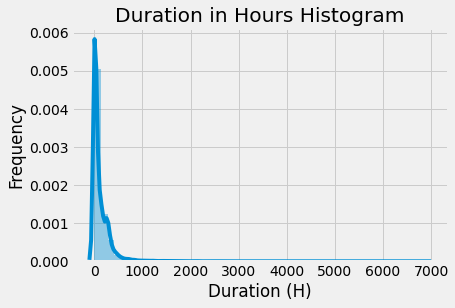

In [ ]:
# CREATE A HISTOGRAM OF Time Duration in Hours for company j
ax = sns.distplot(j_df['hours '])
plt.title("Duration in Hours Histogram")
plt.xlabel('Duration (H)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import plotly.express as px
fig = px.violin(j_df, y="hours ", x="actual_category", box=True, # draw box plot inside the violin
                points="all", 
               )
fig.show()

In [ ]:
import plotly.express as px
fig = px.box(j_df, x="actual_category", y="hours ",color="actual_category",color_discrete_sequence=px.colors.qualitative.Dark24, points="all")
fig.show()

In [ ]:
#Get the geo-locations for each of origin locations
j_df2= pd.read_csv('/content/drive/Shareddrives/IST 718 Project/j1_datatime_loc.csv')

In [ ]:
j_df2.dropna(how='all',subset=None,inplace=False)

Unnamed: 0                 location  ...   longitude  altitude
0               0            Sunnyvale, CA  ... -122.036350       0.0
1               1             Westford, MA  ...  -71.437841       0.0
2               2              Houston, TX  ...  -95.367697       0.0
3               3  Taikoo Shing, Hong Kong  ...  114.215207       0.0
4               4            Sunnyvale, CA  ... -122.036350       0.0
...           ...                      ...  ...         ...       ...
10041       10041     Capistrano Beach, CA  ... -117.671717       0.0
10042       10042           Moscow, Russia  ...   37.617494       0.0
10043       10043       Seoul, South Korea  ...  126.978291       0.0
10044       10044         Bangalore, India  ...   77.591300       0.0
10045       10045            Sunnyvale, CA  ... -122.036350       0.0

[10046 rows x 11 columns]

In [ ]:
#Asign numeric values to hours
j_df2['hours'] =j_df2['hours'].astype(float)

In [ ]:
mapbox_access_token = 'pk.eyJ1IjoidnNtaWxsZXIiLCJhIjoiY2tpMmgwMW10MmZ6cDJ6bnR3cnZ6N2E0eSJ9.Hs3fSyL7D862FtohKmTALg'
px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_mapbox(j_df2, lat="latitude", lon="longitude", color="actual_category", size="hours",
                  color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=10, zoom=2, mapbox_style='dark')
fig.show()

In [ ]:
#Heat Map of company J ticket duration by location
fig = px.density_mapbox(j_df2, lat='latitude', lon='longitude', z='hours', radius=10,
                        center=dict(lat=45, lon=-80), zoom=2,
                        mapbox_style="stamen-toner")
fig.show()
fig.write_html('/content/drive/Shareddrives/IST 718 Project/us_layer_companyJ_map.html', full_html=False, include_plotlyjs='cdn')

In [ ]:
#Drop Nulls and non mumeric columns
j_df3=j_df2[['latitude','longitude','hours']]
j_df3 = j_df3[j_df3['latitude'].notna()]
j_df3.dropna()


latitude   longitude       hours
0      37.368830 -122.036350   44.666667
1      42.579258  -71.437841    6.533333
2      29.758938  -95.367697  255.933333
3      22.287585  114.215207  527.883333
4      37.368830 -122.036350    0.100000
...          ...         ...         ...
10041  33.462528 -117.671717  338.383333
10042  55.750446   37.617494  994.283333
10043  37.566679  126.978291   27.550000
10044  12.979120   77.591300    7.300000
10045  37.368830 -122.036350   20.033333

[9954 rows x 3 columns]

In [ ]:
#Create a heatmap of ticket duration based on call location for company J
import folium 
from folium import plugins
map_heatmap2 = folium.Map([39.912, -76.289], tiles= "CartoDB dark_matter",zoom_start=3, control_scale=True)
j_heat = [[row['latitude'],row['longitude'], row['hours']] for index, row in j_df3.iterrows()]
plugins.HeatMap(j_heat).add_to(map_heatmap2)
map_heatmap2.save('/content/drive/Shareddrives/IST 718 Project/company_j_ticket_duration_call_origin_heat.html')
map_heatmap2

# **Examine Company A and J outliers**

In [3]:
df_a_out = pd.read_csv('/content/drive/Shareddrives/IST 718 Project/a_outlier_data.csv')
df_a_out.head()

Unnamed: 0         location  ...   longitude  altitude
0           0  Ontario, Canada  ...  -86.000977       0.0
1           1    Vienna, Italy  ...   12.620121       0.0
2           2    Sunnyvale, CA  ... -122.036350       0.0
3           3    Sunnyvale, CA  ... -122.036350       0.0
4           4    Sunnyvale, CA  ... -122.036350       0.0

[5 rows x 11 columns]

In [5]:
import plotly.express as px
fig = px.scatter_geo(df_a_out, lon="longitude", lat="latitude", color="actual_category",
                     hover_name="actual_category", size="hours", projection="natural earth")
fig.show()
fig.write_html('/content/drive/Shareddrives/IST 718 Project/companyA_outlier_map.html', full_html=False, include_plotlyjs='cdn')

In [6]:
df_j_out = pd.read_csv('/content/drive/Shareddrives/IST 718 Project/j_outlier_data.csv')
df_j_out.head()

Unnamed: 0         location  ...   longitude  altitude
0           0    Sunnyvale, CA  ... -122.036350         0
1           1     Westford, MA  ...  -71.437841         0
2           2    Sunnyvale, CA  ... -122.036350         0
3           3     Westford, MA  ...  -71.437841         0
4           4  Bridgewater, MA  ...  -70.975043         0

[5 rows x 11 columns]

In [7]:
fig = px.scatter_geo(df_j_out, lon="longitude", lat="latitude", color="actual_category",
                     hover_name="actual_category", size="hours", projection="natural earth")
fig.show()
fig.write_html('/content/drive/Shareddrives/IST 718 Project/companyJ_outlier_map.html', full_html=False, include_plotlyjs='cdn')

In [8]:
import plotly.express as px
df_comp = pd.read_csv('/content/drive/Shareddrives/IST 718 Project/company_outliers.csv')
a = df_comp["hours"].max()
fig = px.bar(df_comp, x="location", y="hours", color="actual_category",
  animation_frame="date_opened", animation_group="hours", range_y=[0,"a"])
fig.show()
fig.write_html('/content/drive/Shareddrives/IST 718 Project/companyAJ_bar_over_time_of_outliers.html', full_html=False, include_plotlyjs='cdn')

In [ ]:

fig = px.scatter_geo(df_a_out, lon="longitude", lat="latitude", animation_frame="date_opened", animation_group="actual_category",
           size="hours", color="actual_category", hover_name="hours",
           projection="natural earth")
fig.show()

In [ ]:
from datetime import datetime
df_a_out.rename(columns={'date_opened':'Date1', 'time_opened':'Time'}, inplace=True)
df_a_out['Date'] = df_a_out[['Date1','Time']].apply(lambda x: ' '.join(x), axis=1)
df_a_out.head()


Unnamed: 0         location  ... altitude              Date
0           0  Ontario, Canada  ...      0.0  2019-12-18 15:02
1           1    Vienna, Italy  ...      0.0  2020-10-02 11:56
2           2    Sunnyvale, CA  ...      0.0  2019-10-08 13:36
3           3    Sunnyvale, CA  ...      0.0  2019-12-16 14:27
4           4    Sunnyvale, CA  ...      0.0  2020-01-09 16:55

[5 rows x 12 columns]

# **Time Series & Moving Average of Outliers**

In [ ]:
fig = px.bar(df_a_out, x="Date1", y="hours")
fig.show()

In [ ]:
df_j_out.rename(columns={'date_opened':'Date1', 'time_opened':'Time'}, inplace=True)
df_j_out['Date'] = df_j_out[['Date1','Time']].apply(lambda x: ' '.join(x), axis=1)
df_j_out.head()


Unnamed: 0         location  ... altitude              Date
0           0    Sunnyvale, CA  ...        0  2019-12-23 13:21
1           1     Westford, MA  ...        0  2019-11-20 10:00
2           2    Sunnyvale, CA  ...        0  2020-06-17 14:32
3           3     Westford, MA  ...        0  2020-04-14 13:25
4           4  Bridgewater, MA  ...        0  2019-12-20 10:22

[5 rows x 12 columns]

In [ ]:
fig = px.bar(df_j_out, x="Date1", y="hours")
fig.show()

In [ ]:
df_a_out['Date1'] =pd.to_datetime(df_a_out.Date1)
df_a_out['EMA'] = df_a_out['hours'].ewm(span=40, adjust=False).mean()

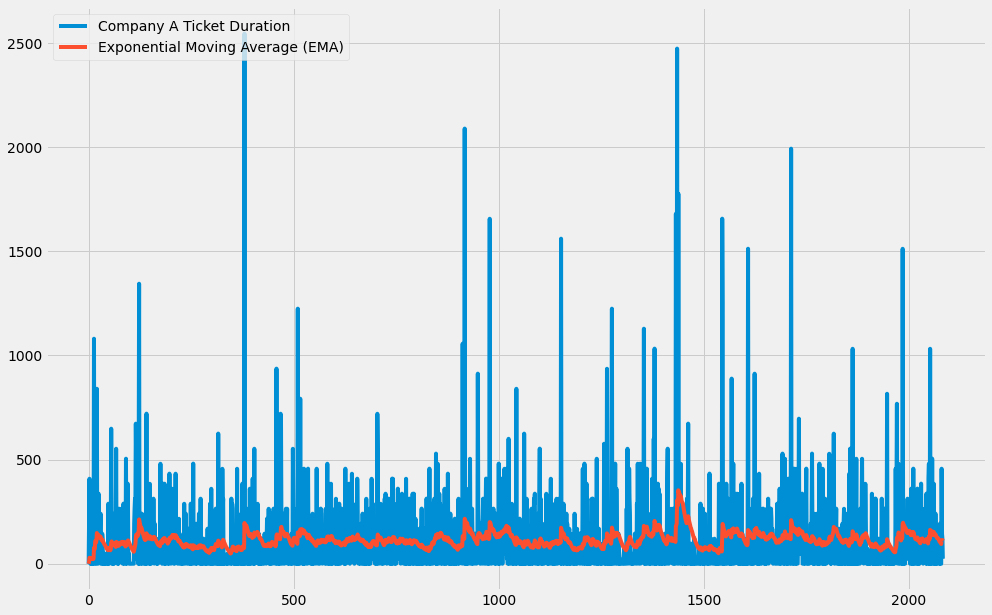

In [ ]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df_a_out['hours'],label='Company A Ticket Duration')
plt.plot(df_a_out['EMA'],label='Exponential Moving Average (EMA)')
plt.legend(loc=2)

In [ ]:
df_j_out['Date1'] =pd.to_datetime(df_a_out.Date1)
df_j_out['EMA'] = df_j_out['hours'].ewm(span=40, adjust=False).mean()

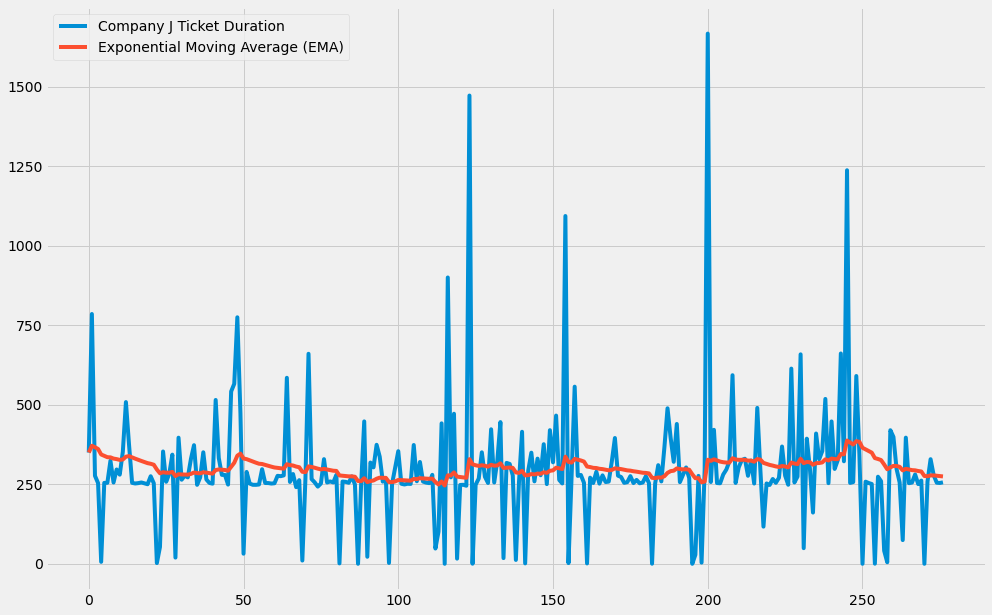

In [ ]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df_j_out['hours'],label='Company J Ticket Duration')
plt.plot(df_j_out['EMA'],label='Exponential Moving Average (EMA)')
plt.legend(loc=2)